In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D ,Conv2D , MaxPooling2D , Input
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from scipy.optimize import fmin_l_bfgs_b

In [ ]:
def VGG_Average_pool(shape):
    vgg = VGG16(input_shape=shape , weights = "imagenet" , include_top= False)
    model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            model.add(AveragePooling2D())
        else:
            model.add(layer)

    return model

In [ ]:
def scale_img(img):
    img = img - img.min()
    img = img / img.max()

    return img

In [ ]:
def unpreprocess(img):
    img[... , 0] += 103.939
    img[... , 1] += 116.779
    img[... , 2] += 126.68
    img = img[... , ::-1]

    return img 

In [ ]:
def gram_matrix(img):
    
    # shape(H , W ,C) ---> shape(C , H*W)
    x = K.batch_flatten(K.permute_dimensions(img , (2 , 1 , 0)))
    
    # shape(C , H*W).dot(shape(H*W , C)) ---> shape(C , C)
    G = K.dot(x , K.transpose(x)) / img.get_shape().num_elements()
    return G

In [ ]:
def style_loss(pred , target):
    return K.mean(K.square(gram_matrix(pred) - gram_matrix(target)))

In [ ]:
img = plt.imread("starry night.jpg")

In [ ]:
img.shape

(188, 268, 3)

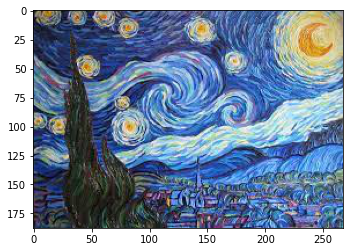

In [ ]:
plt.imshow(img)

In [ ]:
x = img.copy()
x = np.expand_dims(x , axis =0)
x = preprocess_input(x)
batch_shape = x.shape
shape = x[0].shape

In [ ]:
vgg = VGG_Average_pool(shape)

In [ ]:
vgg.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 188, 268, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 188, 268, 64)      36928     
_________________________________________________________________
average_pooling2d_20 (Averag (None, 94, 134, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 94, 134, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 94, 134, 128)      147584    
_________________________________________________________________
average_pooling2d_21 (Averag (None, 47, 67, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 47, 67, 256)      

In [ ]:
symbolic_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith("conv1")]

In [ ]:
symbolic_conv_outputs

[<tf.Tensor 'block1_conv1_9/Relu:0' shape=(None, 188, 268, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_9/Relu:0' shape=(None, 94, 134, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_9/Relu:0' shape=(None, 47, 67, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_9/Relu:0' shape=(None, 23, 33, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_9/Relu:0' shape=(None, 11, 16, 512) dtype=float32>]

In [ ]:
style_model = Model(vgg.input , symbolic_conv_outputs)

In [ ]:
style_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 188, 268, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 188, 268, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 188, 268, 64)      36928     
_________________________________________________________________
average_pooling2d_20 (Averag (None, 94, 134, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 94, 134, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 94, 134, 128)      147584    
_________________________________________________________________
average_pooling2d_21 (Averag (None, 47, 67, 128)       0   

In [ ]:
from keras.utils import plot_model

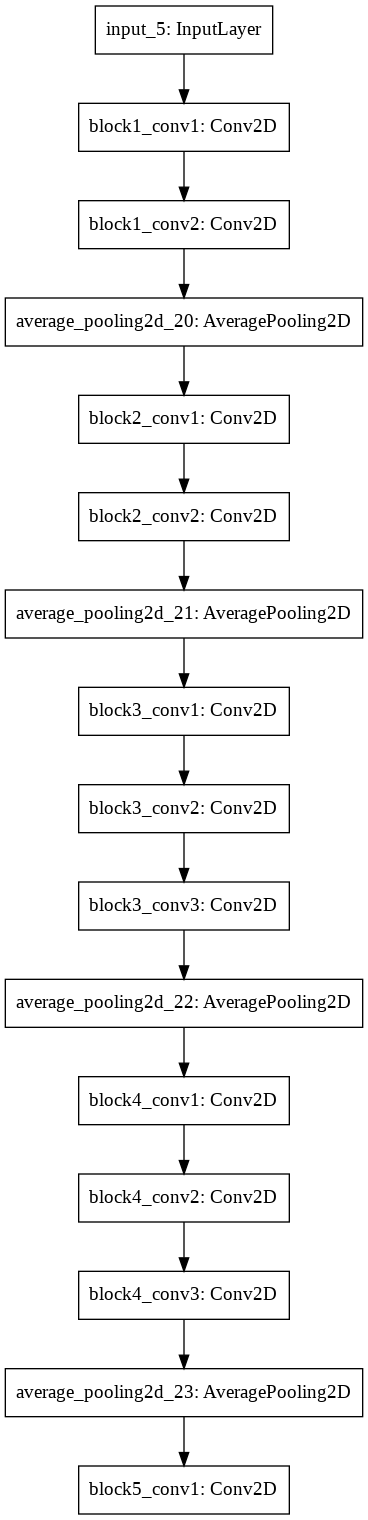

In [ ]:
plot_model(style_model)

In [ ]:
target = []
for y in style_model.predict(x):
    target.append(K.variable(y))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
loss = 0
# weights = [2 , 4 , 6, 8 , 10]
for w , t , output in zip(weights , target , symbolic_conv_outputs):
    loss += K.mean(K.square(gram_matrix(t[0]) - gram_matrix(output[0])))

In [ ]:
loss

<tf.Tensor 'add_34:0' shape=() dtype=float32>

In [ ]:
grads = K.gradients(loss , style_model.input)

In [ ]:
grads

[<tf.Tensor 'gradients_4/block1_conv1_9/Conv2D_grad/Conv2DBackpropInput:0' shape=(None, 188, 268, 3) dtype=float32>]

In [ ]:
get_loss_and_grads = K.function(
                    inputs = style_model.input,
                    outputs = [loss] + grads
                    )

In [ ]:
def loss_grads_wrapper(x_vec):
    l , g = get_loss_and_grads(x_vec.reshape(*batch_shape))
    return l.astype(np.float64) , g.flatten().astype(np.float64)

epochs - 0 --- loss - 6061.35498046875


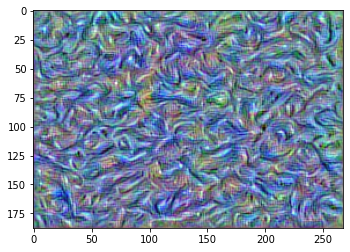

epochs - 1 --- loss - 619.89111328125


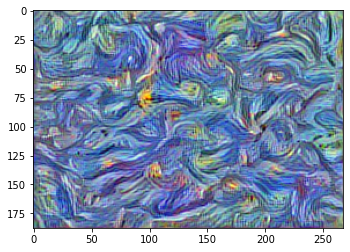

epochs - 2 --- loss - 291.3330993652344


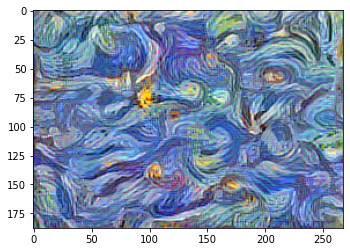

epochs - 3 --- loss - 191.65870666503906


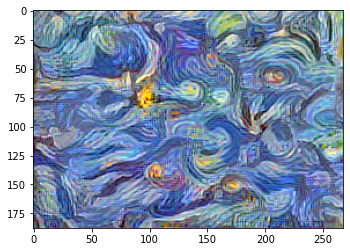

epochs - 4 --- loss - 149.7273406982422


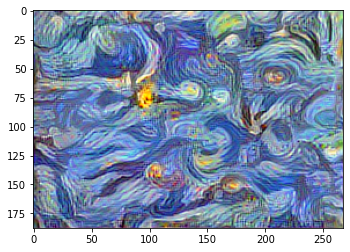

epochs - 5 --- loss - 125.25224304199219


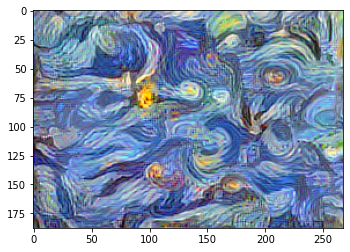

epochs - 6 --- loss - 104.45008087158203


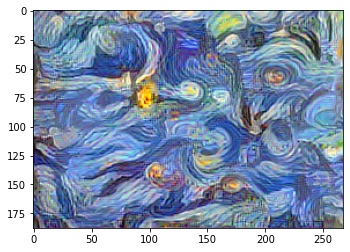

epochs - 7 --- loss - 91.31855773925781


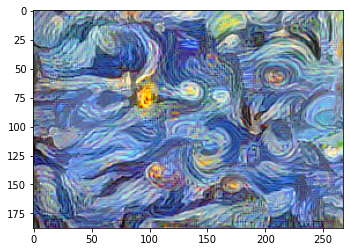

epochs - 8 --- loss - 79.39765930175781


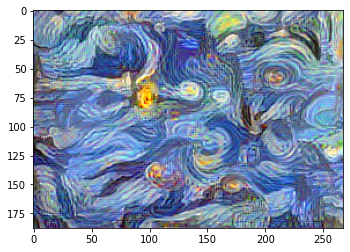

epochs - 9 --- loss - 67.86998748779297


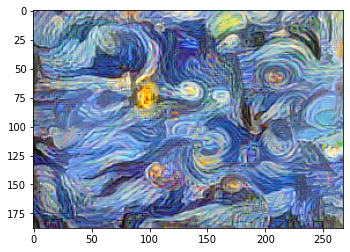

In [ ]:
x = np.random.randn(np.prod(batch_shape))
losses = []

for i in range(10):
    x , l , _ = fmin_l_bfgs_b(
                func = loss_grads_wrapper,
                x0 = x,
                maxfun = 20
                )
    x = np.clip(x , -127 , 127)

    print(f"epochs - {i} --- loss - {l}")
    w = x.copy()
    final_img = scale_img(unpreprocess(w.reshape(*batch_shape)))

    plt.imshow(final_img[0])
    plt.show()
final_img = scale_img(unpreprocess(x.reshape(*batch_shape)))